In [1]:
import numpy as np
import torch
import matplotlib.pylab as pl
import ot
import ot.plot
from tqdm import trange

In [2]:
import os
import sys
sys.path.append('../code/')
from SWGG import SWGG_GG,SWGG_CP,get_SWGG_smooth,quantile_SWGG_CP
from utils import random_slice,sort_to_plan,quantile_to_plan
from generate_data import make_data

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

Used device: cpu


/home/gui/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
if torch.cuda.is_available():
    device='cuda'
    dtype = torch.cuda.DoubleTensor
else:
    device='cpu'
    dtype=torch.DoubleTensor
print(device)

device='cpu'
dtype=torch.DoubleTensor
torch.set_default_tensor_type(dtype)

cpu


# Quantile SWGG

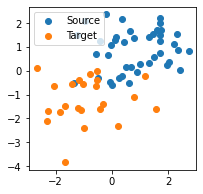

In [5]:
ns=42
nt=23
d=2

X,_=make_data('gaussians',ns,d)
_,Y=make_data('gaussians',nt,d)

pl.figure(figsize=(3,3))
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source')
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target')
pl.legend(loc=2)

In [6]:
a=torch.ones((ns,),dtype=float)/ns

b=torch.randint(1, 5, (nt,),dtype=float)
b/=torch.sum(b)
print('a',a)
print('b',b)

n_proj=300
t=random_slice(n_proj,d).T.float()

a tensor([0.0238, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238,
        0.0238, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238,
        0.0238, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238,
        0.0238, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238,
        0.0238, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238])
b tensor([0.0784, 0.0392, 0.0196, 0.0392, 0.0196, 0.0196, 0.0392, 0.0392, 0.0784,
        0.0784, 0.0392, 0.0196, 0.0392, 0.0392, 0.0196, 0.0588, 0.0196, 0.0784,
        0.0588, 0.0392, 0.0392, 0.0588, 0.0392])


In [7]:
W,r,w_a,w_b,u,v=quantile_SWGG_CP(X,Y,a,b,t)
print('SWGG = ',torch.min(W))

SWGG =  tensor(9.4340)


### Correspondance when ns=nt and uniform masses

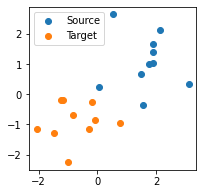

In [8]:
n=10
d=2

X,Y=make_data('gaussians',n,d)

a=torch.ones((n,),dtype=float)/n
b=torch.ones((n,),dtype=float)/n

pl.figure(figsize=(3,3))
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source')
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target')
pl.legend(loc=2)

In [9]:
n_proj=300
t=random_slice(n_proj,d).T.float()

In [10]:
W,r,w_a,w_b,u,v=quantile_SWGG_CP(X,Y,a,b,t)
idx=torch.argmin(W)
print('SWGG quantile', W[idx])

W,w,z=SWGG_CP(X,Y,t)
print('SWGG = ',W[idx])

SWGG quantile tensor(10.0584)
SWGG =  tensor(10.0584, dtype=torch.float32)


In [11]:
P1=quantile_to_plan(r[:,idx],w_a[:,idx],w_b[:,idx],u[:,idx],v[:,idx])
P2=sort_to_plan(w[:,idx],z[:,idx])

In [12]:
C=ot.dist(X,Y)
print(torch.sum(P1*C))
print(torch.sum(P2*C))

tensor(10.0584)
tensor(10.0584)


# quantile SWGG Optim

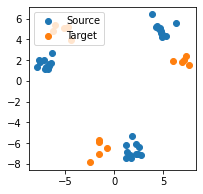

In [51]:
ns=33
nt=15

d=2

X,_=make_data('mog_reg',ns,d)
_,Y=make_data('mog_reg',nt,d)



pl.figure(figsize=(3,3))
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source')
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target')
pl.legend(loc=2)

In [52]:
a=torch.ones((ns,),dtype=float)/ns

b=torch.randint(1, 5, (nt,),dtype=float)
b/=torch.sum(b)

b=torch.ones((nt,),dtype=float)/nt

theta=random_slice(100,d).T.float()

In [53]:
print(torch.min(quantile_SWGG_CP(X,Y,a,b,theta)[0]))

tensor(13.9368)


In [54]:
C=ot.dist(X,Y)
print(ot.emd2(a,b,C))

tensor(13.6671)
